---
title: "Writing Stable Diffusion from Scratch 4"
reading-time: 
date: "2023-3-20"
categories: [fastaipart2,Stable-Diffusion]
---

What you should know and practice after this lecture:<br>
1- Easily plot matrix that is not easily plottable <br>
2- Broadcasting roles <br>
3- Creating sample data <br>
4- meanshift algorithm <br>
5- You can use peresentify to draw on screen <br>
6- Animation

# Clustering

So let's practice that. That's practice what we've learned. So we're going to go to zero two meanshift to practice this. And so we're going to try to exercise our kind of tensor manipulation operation muscles in this section. And the key actually endpoint for this is the homework. And so what you need to be doing is getting yourself to a point that you could implement something like this, but for a different algorithm, why do we care about this? 
Because this is like learning your times table, your times tables. If you're doing, you know, mathematics, it's this kind of like thing that's going to come up all the time. And if you're not good at your times, tables, everything else, a lot more, a lot of other things, particularly at primary school and high school, you know, they they get difficult, you get slower and it's frustrating and you spend time thinking about these mechanical operations rather than getting your work done. It is it's important that when you have an idea about something you want to try or debug or profile or whatever that you can quickly translate that into working code. And the way that code is written for GPUs or even for fast running on on CPU's is using broadcasting, Einstein notation ,metrics multiplications and supper important.

So you've got to, you've got to go to practice super important. So we're going to practice it by running, by developing a clustering algorithm. And the clustering algorithm we're going to work on is something called meanshift clustering, which hopefully you've never heard of before. And I say that because I just think it's a really funny algorithm that not many people have come across. Excuse me, and I think you'll find it really useful. So what is cluster analysis? Cluster analysis is very different to anything that we've worked on in this course so far and that there isn't a dependent variable that we're trying to match, but instead we're just trying to find are there groups of similar things in this data? And those groups we call clusters? And as you can see from the wiki page, there's all kinds of applications of cluster analysis across many different areas. I will say that sometimes cluster analysis can be overused or misused. It's really best for when your your various columns are the same kind of thing and have the same kind of scale. For example, pixels are all the same kind of thing. They're all pixels. So one of the examples they use is market research. So I wouldn't cluster analysis for sociodemographic inputs because they're all different kinds of things. But the example they give here makes a lot of sense, which is looking at data from surveys. So if you've got a whole bunch of like from 1 to 5 answers on surveys. All right. So let's take a look at this. And the way I like to build my algorithms is to create some often to create some synthetic data that I know how I want it to behave.

And so we're going to create six clusters that each cluster is going to have 750 samples in it. So first of all, I'm going to randomly six centroid. And so the centroid is going to be like the middle of where my clusters are. So I'm going to randomly create them. I need to (n_clusters,2). So I need an X and Y coordinate for each one. And so now I'm going to randomly generate data around those six centroid. Okay. So to do that, I'm going to call a little function I made here called Sample, and I'm going to run it on each of those six centroid and show you what that looks like. So here's what that data looks like. So the X's, the six centroid and the colored dots is the data. So if you were given this data without the X's, the idea would be to come out, come back with figuring out where the X's would have been, like where are the where are these clustering around? And so if you can get clusters like that, that's the goal here, is to find out that there's a fewer discretely, distinctly different types of data in your data set. So for example, for images, I've used this before to discover that there are some images that look completely different to all the other ones. For example, they were taken at night time or they're of a different object or something like that. 

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

So how does sample work? Well, we're passing in the centroid, and so what we want is we're going to get back. So each of those centroid contains an X in a Y. So multivariate normal is just like normal. It's going to give you back normally distributed data, but more than one item. That's why it's multivariate. And so we passed in two means a main for X and a mean for our Y. And so that's the mean that we're going to get. And our standard deviation is going to be five. Why do we use torch.diag(tensor([5.,5.])))? That's because we're saying that because that for multivariate normal distributions, there's not just one standard deviation. Each column that you get back, there could also be a connection between columns. The columns might not be independent. So you actually need so it's called a covariance matrix, not just to make, not just a variance. We discussed that a little bit more in lesson 9B if you're interested in learning more about that. Okay, So this is something that's going to give us back random columns of data with this mean and this standard deviation.

And this is the number of samples that we want and this is coming from PyTorch. So PyTorch has a whole bunch of different distributions that you can use, which can be very handy. So there is our data. Okay. So remember, for sample clustering, we we don't know the different colors and we don't know where the X is. That's kind of our job is to figure that out. We might just briefly also look at how to plot. So in this case, we want to plot the X s and we want to plot the data so it looks like this. So what I do is I look through each centroid and I grab that centroid samples and they're just all done in order. So I grab it from i*n_samples: to (i+1)*n_samples, and then I create a scatterplot with the samples on them. And what I've done is I've created an axis here and you'll see y later that we can also pass one in. But I'm not passing one it. And so we create a plot and an axis. And so in that matplotlib, you can keep plotting things on the same axis. So then I plot on the centroid a big x, which is black, and then a smaller x, which is what is that magenta? And so that's how I get these X's. So that's how plot data works. Okay, so how do we create something now that starts with all the dots and returns where the X is are ?  We're going to use a particular algorithm, particular clustering algorithm called meanshift. 

In [6]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [7]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [8]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

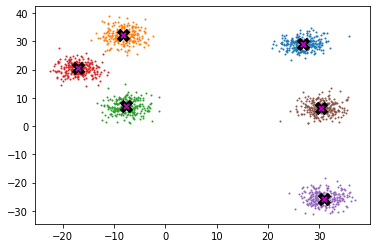

In [9]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

And and meanshift is a nice clustering approach because you don't have to say how many clusters there are. So it's not that often that you're actually going to know how many clusters there are. So we don't have to say quite a few things, like the very popular K means required to say how many in step. You just have to pass them in quite a bandwidth, which we'll learn about, which can actually be chosen automatically. And it can also handle clusters of any shape so they don't have to be bold shaped like that. But they are here. They can be kind of like L-shaped or ellipse shaped or whatever. And so here's what's going to happen. We're going to pick some point. So let's say we pick that point just there. Okay? And so what we now do is we go through each data point, so we pick the first one, and so we then find the distance between that point and every other point. Okay. So we're going to have to say what is the distance between that point and that point? And point and that point and that point and that point and also the ones further away, that point and that point. And you do it for every single point compared to the one that we're currently looking at. Okay. So we get all of those as a big list. And now what we're going to do is we're going to take a weighted average of all of those points. Now That's not interesting without the weighting. If we just take our average of all of the points and how far away they are, we're going to end up somewhere here, right? This is the average of all the points. But the key is that we're going to take an average and find the right spot. The key is we need to find an average that is weighted by how far away things are.

So, for example, this one over here is a very long way away from our point of interest. And so it should have a very low weight and the weighted average where else this point here, which is very close, should have a very high weight in our weighted average. So What we do is we create weights for every point compared to the one that we're currently interested in using a what's called a Gaussian kernel that we'll look at. But the key thing to know is that points that are further away from our point of interest, which is this one, are going to have lower weights. That's what we mean, that they're penalized. The rate at which weights for a zero is determined by this thing that we set at the start called the bandwidth. And that's going to be the standard deviation of our Gaussian. So we take an average of all the points in the dataset, a weighted average weighted by how far away they are. So for our point of interest, right, the this point is going to get a big weight. This point is going to get a big weight. This point is going to get a big weight. That point is going to get a tiny weight. 

That point is going to get an even tiny weight. So it's mainly going to be a weighted average of these points at a nearby. And the weighted average of those points, I would guess, is going to be somewhere around about here. Right. And would have a similar thing for the weighted average of the points near this one. That's going to probably be somewhere around about here or maybe over here. And so it's going to move all of these points in closer. It's almost like a gravity right. They're kind of going to be moved like closer and closer in towards this kind of gravitational center. And then these ones will go towards their own gravitational center and so forth. Okay. 

In [10]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

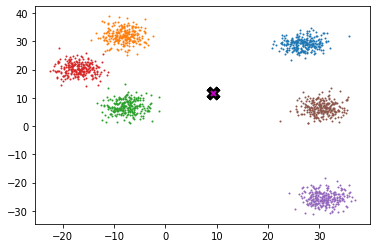

In [11]:
plot_data([midp]*6, data, n_samples)

So let's take a look at it. All right. So what's the gaussian kernel? This is the gaussian kernel, which was a sign in the original March for science back in the days when the idea of not following scientists was considered socially unacceptable. We used to have a March for these things, if you remember. So this is this is not normal. So this is the definition of the gaussian kernel, which is also known as the normal distribution. This is the shape of it. So you've seen it before. And here is that formula copied directly off the science match sign. Okay, here we see the square root, two pi, etc.. 

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

Okay. And bw is the standard deviation. Now what does that look like? It's very helpful to have something that we can very quickly plot any function that doesn't come with matplotlib , but it's very easy to write one. Just say, oh, let's as X, let's use all the numbers from 0 to 10, a hundred of them spaced evenly. That's what linspace Does. it linearly spaced 100 numbers in this range. That's going to be our Xs. So plot those Xs and plot F of X is the Ys. So here's a very nice little plot_func, we want. And here it is. And as you can see here, we've now got something where if you are this like very close to the point of interest, you're going to get a very high weight. And if you're a long way away from the point of interest, you'll get a very low weight. So that's the key thing that we wanted to remember is something that penalizes further away points more. Now, you'll notice here I've managed to plot this function for a bandwidth of 2.5, and the way I did that was using this special thing from functools(functools.partial), . Now, the first thing to point out here is that very often drives me crazy. I see people trying to find out what something is in Jupiter, and the way they do it is they'll scroll up to the top of the notebook and search through the imports and try to find it. That is the dumb way to do it. The smart way to do it is just to type it and press shift enter and it'll tell you where it comes from and you can get its help with  Question Mark and you can get it also source code with two question marks. Okay, So just type it to find out where it comes from. Okay. So this is as Sylver  mentioned in the chat, also known as carrying or partial function application. This creates a new function. So let's just grab it. We create a new function. And this function F is is the function Gaussian, but it's going to automatically pass. BW equals 2.5. So this is a partially applied function. 

In [12]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [13]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

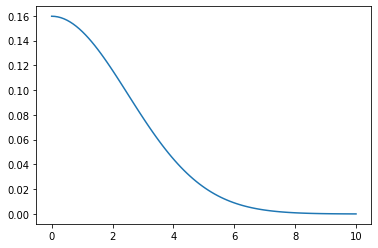

In [14]:
plot_func(partial(gaussian, bw=2.5))

So I could type f of four    f(tensor(4.0)), for example, that's going to be a tensor. There we go. And you can see that's exactly what this is got to for across.
Yep, about .44. So we use partial function application all the time. It's a very, very, very important tool. Without it, for example, plotting this function would have been more complicated with it. It was trivially easy. I guess the alternative, like one alternative which would be fine but slightly more clunky, would be we could create a little function in line so we could have said, Oh, plot a function. Then I'm going to define right now, which is called lamb, which is lambda X, which is Gaussian and of X with a bandwidth of 2.5. You could do that too. You know, it's it's fine, but, but yeah, partials I think are a bit neater, a bit less to think about. 

They often produce some nature and clearer code. Okay. Why did we decide to make the bandwidth 2.5 as a as a rule of thumb, choose a bandwidth which covers about a third of the data. So if we kind of found ourselves somewhere over here, write a bandwith which covers about a third of the data would be enough to cover two clusters ish. So it would be kind of like this big. So somewhere in the middle there. So that's the basic idea. Yeah. So but you can play around with bandwidth and get different amounts of clusters. I should mention, like often when you see something that's kind of on the complicated side, like a Gaussian, you can often simplify things. I think most implementations and write ups I've seen talk about using Gaussians, but if you look at the shape of it, it looks a lot like this shape. So this is a triangular weighting which is just using clamp_min So it's just using a linear with clamp_min And yeah, it occurred to me that we could probably use this just as well. So I did find it.

I decided to define this triangular weighting and then we can try both anyway. So I will start with we're going to use the Gaussian version. All right. So we're going to be move literally moving all the points towards the kind of center of gravity.

In [15]:
f = partial(gaussian,bw=2.5)

In [16]:
f(tensor(4.0))

tensor(0.044)

In [17]:
partial

functools.partial

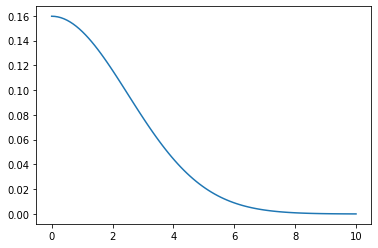

In [18]:
plot_func(lambda x : gaussian(x,bw=2.5))

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [19]:
def tri(d, i): return (-d+i).clamp_min(0)/i

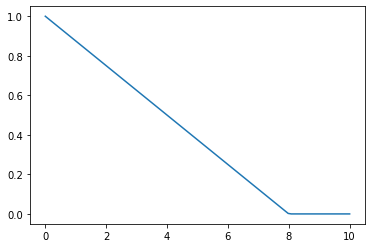

In [20]:
plot_func(partial(tri, i=8))

 So we don't want to mess up our original data so we clone it. It's a PyTorch thing is .clone (data.clone()), it's very handy. And so Big X is our matrix of data. I mean, it's actually a That's right. Matrix of data. Yeah. And then little x will be our first point. And it's pretty common to use big X a capital letters for matrices. So this is our data. This is the first point. 

Okay. So there it is. We're going to start at 26.2, 26.3. So 26.2, 26.3. So somewhere up here, so little x, its shape is just it's a rank one tensor of shape two. Big X is a rank two tensor of 1500 data points by two, the X and Y. And if we call x[None], that would add a unit axis to that. And the reason I'm going to show you that is because we want to find the distance from little x to everything in Big X and the way we do a distance is with minus, but you wouldn't be able to go, you wouldn't be able to go X minus big X and get the right actually to you get the right answer. Let's think about that X shape. Oh, we've got that already. I know actually that is going to work isn't it? So, yes. All right. So you can see why we've got these two versions here. If we do        x[None], we've got something of shape. One comma, two. Now we can subtract that from something, a shape 1500 comma two, because the twos match up because they're the same and the 1500 and the one matches up because we remember our Numpy roles, everything matches up to a unit axis. So it's going to copy this matrix across every of this matrix and it works.

But you remember there's a special trick which is if you've got two shapes of different lengths, we can use the shorter length and it's going to add unit axes to the front to make it as long as necessary. So we actually don't need the x[None]. We can just use little x and it works because it's going to say, is this compatible with this? Well, the last axis, remember we go right to left the last axis matches the second last axis, Oh, it doesn't exist. So we pretend that there's a unit axis, and so it's going to do exactly the same thing as this. So if you have not studied the broadcasting from last week carefully, that might not have made a lot of sense to you. And so definitely at this point, you might want to pause the video and go back and reread the NumPy broadcasting rules from last time and practice them because that's what we just did. We use numpy broadcasting rules and we're going to be doing this dozens more times throughout the rest of the course and many more times, in fact, in this lesson. 

In [21]:
X = data.clone()
x = data[0]

In [22]:
x

tensor([26.204, 26.349])

In [23]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [24]:
x-X

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        ...,
        [-4.568, 17.025],
        [-3.151, 22.389],
        [-4.964, 21.040]])

In [25]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [26]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

 Hi, Dan, The thing I'm using to write on the screen is called presentify.It's this thing here. It's very cool. And a graphics tablet graphics tablets are quite cheap nowadays. Oh, excuse me. I use a cheap Chinese equivalent of a webcam on tablet. All right. Hi, everybody. Welcome back. So we had got to the point where we had managed to get the distance between our first point x and all of the other points in the data. And so just looking at the first eight of them here. So the very first instance is of course zero on the X axis and zero on the Y axis because it is the first point. The other thing is that because we the way we created the clusters is they're all kind of next to each other in the list. So these are all in the first cluster. So none of them are too far away from each other. So now that we've got all the distances, it's easy enough to, well, not the distances on X and Y, it's easy enough to get the distance, the kind of Euclidean distance, so we can just square their difference and sum and square root. And actually maybe this is a good time to talk about norms and to talk about what we just did there. Um, so we've got all these data points. So here's one of our data points and here's the other one of our data points, and there's some, you know, distance across the X axis and there's some distance along the Y axis. So we could call that change in X and change in Y. 

 And one way to think about this distance then is it's this distance here. So to calculate that we couldn't use Pythagoras, so a squared plus b squared equals C squared or in our case so this would be c, a, and b, so, so in our case it would be the square root of the change in X squared plus the change in Y squared. And rather than saying square root, we could say to the power of a half another way of saying the same thing. But there's a different way we could find the distance. We could first go along here and then go up here. And so that one would be change in X, if you like, to the one plus change in Y to the one to the power of one one. Yeah, I got a slightly odd way for reasons you'll see in a moment. It's just this otherwise, in general, if we've got a whole list of numbers, we can add them up. Let's say they're some list V, we can add them up, we can do each one to the power of some number alpha and take that sum to the one over alpha. And this thing here is called a norm. So you might have remember we came across that last week and we come across it again this week. They basically come up, I don't know, they might end up coming up every week. 

They come up all the time, particularly because the two norm, which we could write like this or we could write like this or we could write like this, they're all the two norm this is just saying it's this equation for alpha equals two And Stefano is pointing out we should actually have an absolute value. I'm not going to worry about that. We're just doing real numbers. So I keep things simple. Oh, I guess first higher than one. Now you're probably right for something like three. Yeah, I guess we do need an absolute value there. That's a good point because okay, we could have this one. And so the distance actually has to be the absolute value. So the change in x is the absolute value of that distance. Yes. Thank you, Stefano. Okay. So we'll have the absolute value. Okay. So the two, norm, is what happens when every calls to and we would call this in this case, we would call this the Euclidean distance. But actually where it comes up more often is when you're doing like a lost function.

So the mean squared error is just while the root means squared error, I should say, is just the two norm. Where else the mean absolute error is the one norm. And these are also known as L2 and L1. And remember what we saw in that paper last week. We saw it in this form. There's a two up here which is where they got rid of the square root again. So would have just been a change in x squared plus change in Y squared. And now we don't even need the parentheses. Okay, so all of this is to say that for, you know, this comes up all the time because we're very, very often interested in distances and errors and things like that. I'm trying to think I don't feel like I've ever seen anything other than one or two. So although it is a general concept, I don't think we're going to see probably things other than one or two in this course. I'd be excited if we do, that would be kind of cool. So here we're taking the Euclidean distance, which is the two on. So this has got eight things in it because we've summed it over dimension one. So here's your first homework is to rewrite using torch.einsum, you won't be able to get rid of the x minus x. You'll still need to have that in there. 

But when you've got a multiply followed by a sum, now you want to get rid of the square root. Either you should be able to get rid of the multiply in the sum by doing it in a single torch.einsum. So we're summing up over the first dimension, which is this dimension. So in other words, with summing up the X in the Y axis, okay, so now we can get the, the weights by passing those distance is into our gaussian. And so as we would expect, the biggest weights, it gets up 0.16. So the closest one is itself, it's going to be at a big weight. These other ones get reasonable weights and the ones that are in totally different clusters have weights small enough that at three significant figures they appear to be zero. Okay, so we've got our weights. So there the weights are 1500 long vector and of course our original data is 1500 by two, the X and the Y for each one. So we now want a weighted average. We want this data, we want it's average weighted by this. So normally an average is the sum of your data divided by the count. That's a normal average weighted average item in your data. It's let's put some i's around here. Just to be more clear, each item in your data is going to have a different weight. And so you multiply each one by the weights. And so rather than dividing by n, which is just the sum of ones, we would divide by the sum of weights. So is an important concept to be familiar with. Weighted averages. So we need to multiply every one of these x says by this.



In [27]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [28]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [29]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

Okay, so can we say weights times X? No. All right. Why didn't that work? So remember, we go right to left. So first of all, it's going to say, let's look at the two and multiply that by the 15. Are they compatible? Things are compatible if they're equal or if at least one of them is one. These are not equal and they're not one, so they're not compatible. That's why it says the size of a tensor a, must match. Now, when it says match, it doesn't mean they have to be the same. One of them can be one. Okay. That's what it means to match. They're either or. One of them is one. So that doesn't work. On the other hand, what if this was 1500 comma one? If it was 1500 comma one, then they would match because the one and the two match because one of them's a unit axis and the 1500 and the 1500 match because they had the same. So that's what we're going to do because that would then copy this to every one of these, which is what we want. We want weights for each of these (x,y) tuples. So to add the trailing unit axis, we say every row and a trailing unit axis.(weight[:,None]*X) So that's what that shape looks like. So we can then multiply that by x and as you can see, it's now weighting each of them. And so each of these x's and y is down the bottom, they're all zero. So we can sum that up and then divide by the sum of weights. So let's now write a function that puts all this together so you can see this really important way of like to me, the only way that makes sense to do a particularly scientific numerical programing.

 I actually do all my programing this way, but particularly scientific numerical programing is write it all out step by step, check every piece, have it all that documented for you and for others, and then copy the cells, merge them together and indent them to indent its control+right+spare bracket and put a function header on top. So here's all those things we just did. And now, rather than just grabbing the first x, we enumerate through all of them. So that's the distance we had before. That's the weight we had before. There's the product we had before. And then finally some across the rows divide by the sum of the weights. So that's going to calculate for i`s It's going to move. So it's actually changing Capital X, so it's changing the i`s thing and capital X so that it's now the weighted sum. Oh, actually sorry, the weighted average of all of the other data weighted by how far it is away. So that's going to do a single step. So the main shift update is extremely straightforward, which is clone the data, iterate a few times and do the update. So if we run it, take 600 milliseconds. And what I've done is I've plotted the centroid moved by two pixels or two one up two pixels, two units so that you can see them and so you can see the dots is where our data is. And they're dots now because every single data point is on top of each other on a cluster. And so you can see they are now in the correct spots. So it is successfully clustered our data.

In [30]:
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [31]:
weight[:,None].shape

torch.Size([1500, 1])

In [32]:
weight[:,None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [33]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [34]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [35]:
%time X=meanshift(data)

CPU times: user 1.3 s, sys: 13.4 ms, total: 1.32 s
Wall time: 1.44 s


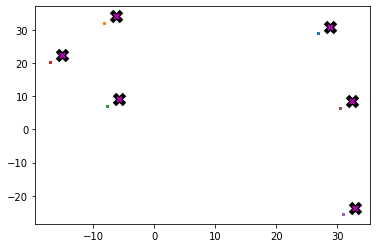

In [36]:
plot_data(centroids+2, X, n_samples)

So that's great news. And so we could test out our hypothesis. Could we use triangular just as well as we could have used Gaussian. So control slash comments and on comments, yeah, we got exactly the same results. So that's good. It's really important to know these keyboard shortcuts hit H to get a list of them. Some things that are really important don't have keyboard shortcuts. So if you click help edit keyboard shortcuts. This list of all the things Jupyter can do and you can add keyboard shortcuts to things that don't have them. So for example, I always add keyboard shortcuts to run all cells above and run all cells below. As you can see, I type Q and then A for above and Q and then B for below. All right. Now that was kind of boring in a way, because it did five steps, but we just saw the result. What did it look like? One step at a time. This isn't just fun. It's really important to be able to see things happening one step at a time because there are so many algorithms we do which are like updating weights or updating data, you know? So for stable diffusion, for example, very likely to want to show, you know, your incrementally denoising and so forth. So in my opinion, it's important to know how to do animations. And I found the documentation for this unnecessarily complicated because it's a lot of it's about how to make them performant. But most of the time we probably don't care too much about that. So I want to show you a little trick, a simple way to create animations without any trouble. So that matplotlib animation has something called FuncAnimation. That's what we're going to use to create an animation. You have to create a function and the function you're going to be calling FuncAnimation  passing in the name of that function and saying how many times to run it. And that's what this frames the argument that says run this function this many times and then create an animation that that basically contains the result of that with a 500 millisecond interval between each one. So what's this do one going to do to create one frame of animation? We will call our one_update.

Here it is one_update, right? We're going to call this that's going to update our access and then we're going to have an access which we've created here. So we're going to clear whatever was on the plot before and plot our new data on that access. And then the only other thing you need to do is that the very first time it calls it, we want to plot it before running and d is going to be passed automatically the frame number. So for the zeroth frame, we're going to not do the update, but it's going to plot the data as it is already. I guess another way we could have done that would have been just to say if d then do the update the update, I suppose that should work too. Maybe it's even simpler. Let's see if I just break it. Okay So we're going to clone our data. We're going to create our figure in our subplots vertical FuncAnimation calling do_one 5 times, and then we're going to display the animation. And so let's see, so HTML takes some HTML and displays it and to_jshtml(), creates some HTML.

 So that's why it's created. This HTML includes JavaScript. And so I click run one, two, three, four, five. That's the five steps. So if I click loop, you'll see them running again and again. Fantastic. So that's how easy it is to create a matplotlib animation. So hopefully now you can use that to play around with some fun stable fusion animations as well. You don't just have to use to to_jshtml. You can also create Oopsie Daisy. You can also create movies. For example. So you can call to_html5_video would be another option. And you can save an animation as a movie file. So this okay, all these different options for that, but hopefully that's enough to get you started. So for your homework, I would like you when you create your k means or whatever, to try to create your own animation or create an animation of some stable diffusion thing that you're playing with. So don't forget this important ax.chear().without the ax.chear(), it prints it on top of the last one, which sometimes is what you want To be fair. But in this case, it's not what I wanted. All right, So kind of slow half a second for not that much data, I'm sure would be nice. It was faster. Well, the good news is we can GPU accelerate it. The bad news is it's not going to GPU You accelerate that Well, because of this loop, this is looping 1500 times. If we so looping is not going to run on the GPU. 

 

## Animation

In [37]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [38]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [39]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

So the best we could do with this would be to move all this to the GPU. Now the problem is that calling something the GPU 1500 times from Python is a really bad idea because there's this kind of huge communication overhead of this of flow of control and data switching back between the CPU and the GPU. It's the kernel launching overhead. It's bad news. So you don't want to have a really big fast python loop that inside it calls cuda code. GPU code. So we need to make all of this run without the loop, which we could do with broadcasting. So let's roll up our sleeves and try to get the broadcast version of this working. So generally speaking, the way we tend to do things with broadcasting on a GPU is we create batches or mini batches. So to create batches or mini batches, we don't just call them batches. Nowadays, we create a batch size. So let's say we're going to do a batch size of five, so we're going to do five at a time. All right, so how do we do five at a time? This is only doing one at a time. How do we do five at a time last before it's final data and this time little x for our testing. So I've got to do everything ahead of time. Little tests as we always do. This is not now X[0] anymore, but it's X colon bs (X[:bs]), so it's the first five. This is now the first five items. Okay, so little x is now a five by two metrics. This is how mini batch the first five items as before. Our data itself is 1500 by two. All right. So we need a distance calculation.

But previously our distance calculation, previously a distance calculation only worked if Little x was a single number and it returned just the distance is from that to everything in Big X. But we need something that's actually going to be return a Matrix right. We've got let's say we've got five by two in little x and then in big X we've got something much bigger not to scale, obviously we've got 1500 by two. And what is the distance between these two things? Well, if you think about it, there's going to be a distance between item one and item one, but there's also going to be a distance between item one, item two, and there's going to be a distance between let's use a different color for the next one, item two and item one, right? So the output of this is actually going to be a matrix. The distances are actually going to give us a matrix where I mean, it doesn't matter which way around, we do what we can decide, but if we it this way around for each of the five things in the mini batch, there will be 1500 distances. The distance between every one. So we're going to need to do a broadcasting to do this calculation. So this is a function that we're going to create and it's going to create this, as you can see, five by 1500 output. But let's say how we get it. So can we do X minus x? No, we can't. Why is that? That's because big X is 1500 by two and little x is five by two.

So it's going to look at remember our roles right to left these compatible? Yes they are They're the same these compatible. No, they're not. Okay. Because they're different. So that's not possible to do What if though we want it to What if we insert in big X and axis at the start here and in little x we add an axis in the middle here then now these are compatible because you've got they're the same because I should use arrows really? They are compatible because one of them is a one. And these are compatible because one of them is a one as well. So they are all compatible. And what it's going to do is it's going to do the subtraction between these directly and it's going to copy this across all 1500 rows. It will copy it. This is going to be copied and then this  across five rows, and then this will be copied across these 1500 rows because what broadcasting does, it's not really copying, but it's effectively copying. And so that gives us it can now subtract them and that gives us what we wanted, which is five by 1500 and then also by two because there's both the x and the y. So that's why this works. That's what this is doing here. It's taking the subtraction, it's squaring them, and then summing over that last shortest axis, summing over the X and the Y squids and then take square root. I don't know why as it touched that square root, we could just put dot square root at the end. But same, same. In fact, it's worth mentioning that. So most things that can do on tensors, you can either write torch. as a function or you can write it as a method. Generally speaking, both should be fine. Not everything, but most things work in both ways. Okay, so now we've got this matrix, which is five by 1500. And the nice thing is that our Gaussian kernel doesn't actually have to be changed to get the weights, believe it or not. And the reason for that is now how do we get the source code? I could move back up there or I can just type Gaussian question mark, question mark and see it. And the nice thing is that this is just this is a scalar, so it broadcasts over anything and then this is also just a scalar. So this is all going to work fine without any fiddling around. Okay, so now we've got a 5, 1500 a weight. So that's the weight for each of the five things. There are mini batch each of the 1500 things, each of them as compared to. And then we've got the shape of the data itself, X.shape, which is the 1500 points. So now we want to apply each one of these weights to each of these columns. So we need to add a unit access to the end set at a unit, access to the end, we could say colon, comma, colon, common, none, but dot, dot, dot means all of the axes up until however many you need. So in this case, the last one comma None[...,None].



## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [40]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [41]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [42]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [43]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [44]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [45]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [46]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [47]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

So this is going to add an access to the end. So this is going to turn this is going to turn weight dot shape from five comma  1500 to 5 comma 1500 from a one. And this is going to add an access to the start. Remember, it's the same as X[None] = X[None,:,:]. And so let's check our rules left, right to left. These are compatible because one of them is one. These are compatible because they're both the same. And these are compatible because one of them is one. Okay? So it's going to be copying each weight  across to each of the X and Y, which is what we want. We want to we want to weight both of those components and it's going to copy each of the 1500 points sorry, each of the point five times, because we do in fact want to wait every one of the five things now, mini batches, the separate set of weights for each of them. So that sounds perfect. So that's how I think through these calculations. Okay. So we can now do that multiplication, which is going to give us something of five by 1500 by two, because we end up with the maximum of our ranks. And then we sum up over those 1500 points and that's going to give us now five new data points. Now, something that you might notice here is that we've got a product and a sum

In [48]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [49]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

 And when you say a product and a sum that tells you maybe we should use einsum. So in this case, we've got our weight, we've got five by 1500. So let's call those i and j As for the five and 1500 we've got, the X is 1500 by two. Now we want to take the product of that and that so wanted to use the same name for this row. So he use j again. And then k is the number of rows, that's the two. And then we want to end up with ik. So einsum, exactly the same result. That's great. But you might recognize this. That's exactly the einsum Something we had just before when we were doing matrix multiplication. Oh, that is a matrix multiplication. We've just re-invented matrix multiplication using this rather nifty. So we could also just use that. And so, you know, again, this is like what I was playing around with this morning as I started to look at this and I was thinking like, Oh, you know, can we simplify this? I don't like this kind of like messing around of axes and summing over dimensions and whatnot. And so it's nice to get things down to Einstein or better still, get down to matrix multipliers. It's just clearer, you know, it's stuff that we recognize because we use them all the time they all work performance would be pretty similar. I suspect. Okay, so now that we've got that, we then need to do our sum and we've got our five points. This is our five denominators. So we've got our numerator that we calculated up here for our weighted for our weighted average. The denominator is just the sum of the weights, remember.

In [50]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [51]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [52]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

And so numerator, divided by denominator is our answer. So again, we've gone through every we've checked out all the dimensions all along the way. So nothing's going to surprise us. Don't try and write a function like this. Just bang from scratch. Right. You're going to drive yourself crazy. Instead, do it step by step. So here's our meanshift algorithm, clone the data, go through five iterations, and now go from 0 to n and batch size at a time. So Python has something called slices so we can create a slice of X starting at one up to i + batch size. Right. Unless it's gone past, in which case use n. And so then we're just copying and pasting each of the lines of code that we had before. Actually had us copy the cells and merge them. Of course I don't actually copy and paste because it's slow and boring and there's my final step to create the new X[s]. And so notice here s is not a single thing. It's a slice of things you might not have seen slice before, but this is just internally what Python's doing when he is  :,  And it's very convenient when you to use the same slice multiple times. Okay, so let's do that using Cuda. I would run it first without cuda, but I mean, I've done all the steps before, so it should be fine so puppet on the GPU and run meanshift and let's see how long that takes. It takes one millisecond and previously without GPU, it took 400 milliseconds. And you know, the other thing we should probably think about doing is looking at other batch sizes as well because now we're looping over batches, right? So if we make the batch size bigger that for loop, it's going to do less looping. So what if we make that 16? Will that be any faster?

In [53]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [54]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

Oh, I see. Thank you. People on YouTube pointing out that I'm passing batch size, so I actually need to put it here. All right. So if we used a batch size of five, I wonder is missing. Oh, look at that. I've totally made it slow now. And in 57 milliseconds. Haha. Okay. 64, All right. Finally, that makes much more sense. Okay, so the bigger, bigger is better. And I guess we could actually do all 5000 at once. Probably nice. All right. Thank you YouTube friends, for solving that bizarre mystery. Okay. All right. So that's pretty great. I mean, you know, to say that we can you optimize a meanshift like actually google for this to see if it's been done before. And it's the kind of thing that people, like write papers about. So I think it's great that we can do it so easily with PyTorch. And it's the kind of thing that previously had been considered, you know, a very challenging academic problem to solve. So maybe you can do something similar with some of these. Now, I haven't told you what these are. So part of the homework is to go read about them and learn about them. dbscan, funnily enough, actually is an algorithm that I accidentally invented and then discovered a year later had already been invented.

 LSH comes up all the time, so that's great. And in fact I have a strong feeling and I've been thinking about this for a while, that something like LSH could be used to speed this whole thing up a lot. Because if you think about it and again, maybe already this already exists, I don't know. But if you think about it, when we did that distance calculation, the vast majority of the the weights or nearly zero. And so it seems pointless to create that big you know kind of eventually 1500 by 1500 matrix. That's like it'd be much better if we just found the ones that were like pretty close by and just took their average. And so you want an optimized nearest neighbors, basically. And so this is an example of something that can give you a, an, a kind of a fast nearest neighbors algorithm or, you know, there are things like. kd trees and trees and stuff like that. So if you want to, like have a bonus bonus, invent a new meanshift algorithm which picks only the closest points to avoid the quadratic time. All right. So not very often you get an assignment, which is to invent a new meanshift algorithm, I guess a super, super bonus. Super, super bonus. Publish a paper that describes it. All right. You definitely get four points. If you do that, we'll give you a number of points equal to the impact factor of the journal. You get it published in. Okay. So what I want to do now is move on to calculus, which for some of us may not be our favorite topic. Yeah, that's funny. I found out that I in some version here already, I didn't notice. Okay. Or is ahead of his time. That guy. Let's talk about calculus. If you're not super comfortable with derivatives and what they are and why we care. called The Essence of Calculus, which I strongly recommend watching. It's just a pleasure, actually, to watch, as is everything that is on 3blue1brown.

In [55]:
data = data.cuda()

In [56]:
X = meanshift(data).cpu()

In [57]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

6.06 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


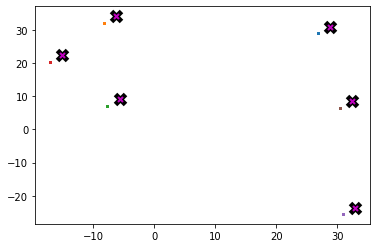

In [58]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

Where do we start. So the good news is just like you don't have to know much linear algebra at all, you basically just need to know about matrix multiplication. You also don't need to know much calculus at all. Just derivatives. So let's think about like what derivatives are. So I'm going to borrow actually the same starting point that when 3blue1brown uses one of their videos is to consider a car, and we're going to see how far away from home it is at various time points. Okay. So after a minute, let's say after a second, it's traveled five meters and then after 2 seconds, it's traveled ten meters. Okay. And after 3 seconds, you can probably guess it's traveled 15 meters. So there's this concept here of a I got it the wrong way around. Obviously. So time, distance. Okay. So there's this concept of Yeah, of like location. It's like how far how far if you traveled at a particular point in time. So we can look at one of these points and find out how far that car has gone. We could also take two points and we can say, where did it start at the start of those two points and where did it finish at the end of those two points. And we can say between those two points, how much time passed and how far did they travel? In 2 seconds. They traveled ten meters. So we could now also say, all right, well, the slope of something, let's rise over, run. You'll see.ten meters in 2 seconds. And notice we don't just divide the numbers. We also divide the units. We get five meters per second. So this here is now changed the dimensions entirely. We're now not looking at distance, but we're looking at speed or velocity. And it's equal to rise over run. It's equal to the rate of change. And what it says really is as time the X-axis goes up by one second, what happens to the distance in meters as one second passes? How does the number of meters change? 

And so maybe these aren't points at all. Maybe there's a function that it's a continuum of points, and so you can do that for the function. So the function is a function of time. Distance is a function of time. And so we could say, what's the slope of that function? And we can get the slope from point A to point B using over run. So from T one to T two the amount of distance, that's the amount of time that's passed is T2 minus T1. That's how much time has passed that say this is t one, this is t two and the distance that they've traveled while they've moved from wherever they are at the end to wherever they were at the start. So that's the change in distance, divided by the change in time, Change in distance, divided by change in time. Okay, So that's why. So another way. Now the thing is, when we talk about calculus, we talk about finding a slope, but we talk about finding a slope of something that's more often more tricky than this, right? We have slopes of things that look more like this and we say, what's this slope absent Terrible attempt at drawing? Let's maybe put it over here because I'm left handed. What's this slope now? What does it mean to have like the idea of a velocity at an exact moment in time? It doesn't mean anything, you know, at an exact moment in time, you're just like it's frozen. Right? What's happening exactly now? But what you can do is you can say, well, what's the change in time between a bit before a point and bit after a point? And what's the change in distance between a bit before our point and a bit after our point? And so you can do the same kind of rise over run the thing, right? But you can make that distance between T2 and T1 smaller and smaller and smaller. So let's rewrite this in a slightly different way. Let's call the denominator the distance between T1 plus a little bit  I'll call it d, it's that minus T1. So this is T2 = T1+d, right? 

It's T1 pluss a little bit. So we say oh his T1. Let's add a little bit and notice that we when we write it this well let's actually, let's do the rest of it. So now f52 becomes f of t one plus a little bit and this is the same. And now notice here that t one plus t minus t one. We can delete all that because it just comes out to d. So this is another way of calculating the slope of our function. And as you get smaller and smaller and smaller, we're kind of getting a triangle that's tinier and tinier and tinier and it still makes sense it still that some time has passed and the car has moved, right? But it's just smaller and smaller amounts of time. Now, if you did calculus at that college or at school, you might have done all this stuff messing around with limits, Epsilon Delta and blah, blah, blah. I've got really good news. It turns out you can actually just think of this d as a really small number where d is the difference if, uh, it's. And so when we calculate the slope, we can write it in a slightly different way as the change in dY divided by the change in dX, this here is the change in dY, and this here is the change in dX. And so in other words, this here is a very small number. A very small number, and this here is the result in the function of changing by that very small number. And this way of thinking about calculus is known as the calculus of in infinitesimal.  and it's how Leibniz its originally developed it. And it's been turned into a whole theory nowadays. And the reason I talk about it here is because when we do calculus, you'll see me doing stuff all the time where. I act like the dx is a really small number. And when I was at school I was told I wasn't allowed to do that. I've since learned that it's totally fine, do that. 

So, for example, next lesson, we're going to be looking at the chain role, which looks like this. The dy/dx equals to dy/du * du/xd And I'm just going to say, Oh, these two small numbers can cancel out. And that's why obviously they're the same thing and that's all going to work out nicely. So what do you know? What would be very helpful would be if before the next lesson, if you're not totally up to date with your, you know, remembering all the stuff you did in high school about calculus is watch the 3blue1brown Course, we are not going to be looking. I don't think at all that integration. So you don't have to worry about that. Also we are not going to on the whole be doing any derivatives by hand. So for example, there are rules such as to why the dy/dx, if y equals x squared is 2x, these kind of rules, you're not really going to have to learn because PyTorch is going to do them all for you. The one that we care about is going to be the chain role that we're going to learn about that next time. Okay. I hope I don't get beaten to a bloody pulp the next time I walk into a mathematician's conference, I suspect I might. But hopefully I get away with this. I think it's safe. We'll see how we go. So thanks, everybody very much for joining me and really look forward to seeing you next time where we're going to do backpropagation from scratch. We've already learned to multiply matrices, so once we've got backpropagation as well, we'll be ready to train a neural network. All right. Thanks So.
